# Assignment 4

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

This assignment requires that you to find **at least** two datasets on the web which are related, and that you visualize these datasets to answer a question with the broad topic of **weather phenomena** (see below) for the region of **Ann Arbor, Michigan, United States**, or **United States** more broadly.

You can merge these datasets with data from different regions if you like! For instance, you might want to compare **Ann Arbor, Michigan, United States** to Ann Arbor, USA. In that case at least one source file must be about **Ann Arbor, Michigan, United States**.

You are welcome to choose datasets at your discretion, but keep in mind **they will be shared with your peers**, so choose appropriate datasets. Sensitive, confidential, illicit, and proprietary materials are not good choices for datasets for this assignment. You are welcome to upload datasets of your own as well, and link to them using a third party repository such as github, bitbucket, pastebin, etc. Please be aware of the Coursera terms of service with respect to intellectual property.

Also, you are welcome to preserve data in its original language, but for the purposes of grading you should provide english translations. You are welcome to provide multiple visuals in different languages if you would like!

As this assignment is for the whole course, you must incorporate principles discussed in the first week, such as having as high data-ink ratio (Tufte) and aligning with Cairo’s principles of truth, beauty, function, and insight.

Here are the assignment instructions:

 * State the region and the domain category that your data sets are about (e.g., **Ann Arbor, Michigan, United States** and **weather phenomena**).
 * You must state a question about the domain category and region that you identified as being interesting.
 * You must provide at least two links to available datasets. These could be links to files such as CSV or Excel files, or links to websites which might have data in tabular form, such as Wikipedia pages.
 * You must upload an image which addresses the research question you stated. In addition to addressing the question, this visual should follow Cairo's principles of truthfulness, functionality, beauty, and insightfulness.
 * You must contribute a short (1-2 paragraph) written justification of how your visualization addresses your stated research question.

What do we mean by **weather phenomena**?  For this category you might want to consider seasonal changes, natural disasters, or historical trends.

## Tips
* Wikipedia is an excellent source of data, and I strongly encourage you to explore it for new data sources.
* Many governments run open data initiatives at the city, region, and country levels, and these are wonderful resources for localized data sources.
* Several international agencies, such as the [United Nations](http://data.un.org/), the [World Bank](http://data.worldbank.org/), the [Global Open Data Index](http://index.okfn.org/place/) are other great places to look for data.
* This assignment requires you to convert and clean datafiles. Check out the discussion forums for tips on how to do this from various sources, and share your successes with your fellow students!

## Example
Looking for an example? Here's what our course assistant put together for the **Ann Arbor, MI, USA** area using **sports and athletics** as the topic. [Example Solution File](./readonly/Assignment4_example.pdf)

# Read GHCN Data

The file can be found on [Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/ghcnd-stations.txt).

FORMAT OF "ghcnd-stations.txt"
```
Variable   Columns   Type
ID            1-11   Character
LATITUDE     13-20   Real
LONGITUDE    22-30   Real
ELEVATION    32-37   Real
STATE        39-40   Character
NAME         42-71   Character
GSN FLAG     73-75   Character
HCN/CRN FLAG 77-79   Character
WMO ID       81-85   Character
```

FORMAT OF DATA FILES (".dly" FILES)
```
ID            1-11   Character
YEAR         12-15   Integer
MONTH        16-17   Integer
ELEMENT      18-21   Character
VALUE1       22-26   Integer
MFLAG1       27-27   Character
QFLAG1       28-28   Character
SFLAG1       29-29   Character
VALUE2       30-34   Integer
MFLAG2       35-35   Character
QFLAG2       36-36   Character
SFLAG2       37-37   Character
  .           .          .
  .           .          .
  .           .          .
VALUE31    262-266   Integer
MFLAG31    267-267   Character
QFLAG31    268-268   Character
SFLAG31    269-269   Character
```
For reading subtract one from Columns
All related format information can be found [here](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt)-

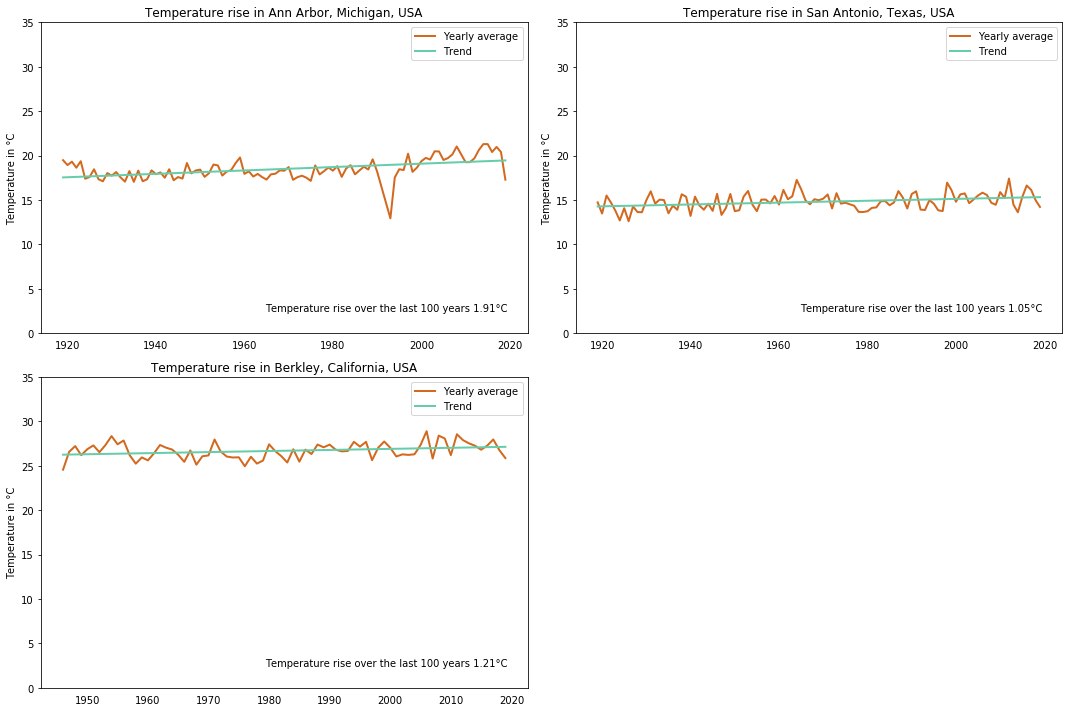

In [20]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

data_path = 'ghcnd_hcn/'

def read_ghcn_stations():
    col_specification = [(0, 11), (41, 71)]
    col_names = ['id', 'name']
    df = pd.read_fwf('ghcnd-stations.txt', colspecs=col_specification, header=None, names=col_names)

    gsn_station_names = ['ANN ARBOR U OF MICH', 'SAN ANTONIO INTL AP', 'BERKELEY']
    gsn_name = ['Ann Arbor, Michigan, USA', 'San Antonio, Texas, USA', 'Berkley, California, USA']
    df = df[df['name'].isin(gsn_station_names)]
    df['name'] = gsn_name
    return df.reset_index(drop=True)

def calc_start_year(time_span=50):
    current_year = datetime.datetime.now().year
    start_year = current_year - time_span
    return start_year, current_year

def read_ghcn_daily(station_name, time_span=50):
    start_year, current_year = calc_start_year(time_span)
    col_specification = [(0, 11), (11, 15), (15, 17), (17, 21)]
    col_names = ['id', 'year', 'month', 'type']
    for day_counter in range(0, 31):
        col_specification.append((21+8*day_counter, 26+8*day_counter))
        col_names.append(day_counter+1)
    df = pd.read_fwf('ghcnd_hcn/{}.dly'.format(station_name), colspecs=col_specification, header=None, names=col_names)
    df = df[((df['year'] >= start_year) & ((df['type'] == 'TMAX') | (df['type'] == 'TMIN')))].copy()
    df.replace(-9999, np.nan, inplace=True)
    df['avg'] = df.iloc[:, 4:35].mean(axis=1) / 10.0
    df.drop(range(1, 32), axis=1, inplace=True)
    return df

def prepare_ghcn_daily(station_name, time_span=50):
    df = read_ghcn_daily(station_name, time_span=time_span)
    df_avg = df[(df['type'] == 'TMAX')].groupby(['year']).mean().reset_index()

    X = df_avg['year'].values.reshape(-1, 1)
    Y = df_avg['avg'].values.reshape(-1, 1)
    linear_regressor = LinearRegression()
    linear_regressor.fit(X, Y)
    Y_pred = linear_regressor.predict(X)
    return X, Y, Y_pred, linear_regressor.coef_[0][0] * 100.0

time_span=100

df = read_ghcn_stations()
fig = plt.figure(figsize=(15,10))

for n in range(3):
    X, Y, Y_pred, t_raise = prepare_ghcn_daily(df.iloc[n]['id'], time_span=100)

    ax = fig.add_subplot(2, 2,  n + 1)
    plt.plot(X, Y, color='chocolate', linewidth=2)
    plt.tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=True) # labels along the bottom edge are off
    plt.ylabel('Temperature in °C')
    plt.plot(X, Y_pred, color='mediumaquamarine', linewidth=2)
    ax.set_title('Temperature rise in {}'.format(df.iloc[n]['name']))
    ax.set_ylim(bottom=0, top=35)
    ax.annotate('Temperature rise over the last {} years {:0.2f}°C'.format(time_span, t_raise), xy=(1, 0),
                    xycoords='axes fraction',
                    xytext=(-20, 20),
                    textcoords='offset pixels',
                    horizontalalignment='right',
                    verticalalignment='bottom')
    ax.legend(['Yearly average', 'Trend'])

plt.tight_layout()
plt.show()

